In [1]:
import sys
sys.path.append("/nfs/gatsbystor/nicholasg/replay_trajectory_classification")
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
organized_data_folder = "/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022/"
processed_data_folder = "/nfs/gatsbystor/nicholasg/striatal_replay/processed_data"
open_ephys_folder = "/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/"
figures_folder = "/nfs/gatsbystor/nicholasg/striatal_replay/figures"

Fs = 30000.0

In [3]:
spikes = np.load(os.path.join(processed_data_folder, "spikes.npy")).T.astype(np.float64)
position = np.load(os.path.join(processed_data_folder, "position.npy")).astype(np.float64)
display(spikes)
display(position)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([   0.        ,    0.        ,    0.        , ..., -265.65648489,
       -265.65648489, -265.65648489])

In [4]:
def get_nonempty_spikes_in_window(spikes, start, end):
    return spikes[:, (~((spikes[start:end] == 0).all(axis=0)))]

def get_time_mask_where_spikes_occur_in_window(spikes, start, end):
    mask = np.zeros(len(spikes)).astype(bool)
    mask[start:end] = ~((spikes[start:end] == 0).all(axis=1))
    return mask

In [5]:
movement_var = estimate_movement_var(position, 60)
movement_var

5373.462465216087

In [18]:
idxs = np.where(np.diff(position) < -500)[0]
idxs = np.insert(idxs, 0, 0)
trial_number = 3

start = idxs[trial_number - 1]
end = idxs[trial_number]

movement_var = estimate_movement_var(position[start:end], 60)
decoder = SortedSpikesDecoder(movement_var=movement_var,
                                 replay_speed=1,
                                 spike_model_penalty=0.5,
                                 place_bin_size=np.sqrt(movement_var))

# start = 0
# end = int(len(spikes) * 0.1)
# start = 0
# end = 10_000

actual_spikes = get_nonempty_spikes_in_window(spikes, start, end)
decoder.fit(position[start:end], actual_spikes[start:end])

/nfs/gatsbystor/nicholasg/striatal_replay/.venv/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 13.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=4357.351645393659,
                    place_bin_size=66.01023894361889, position_range=None,
                    replay_speed=1, spike_model_penalty=0.5,
                    transition_type='random_walk')

In [19]:
# start = end
# end = int(len(spikes) * 0.2)
# start = 0
# end = int(len(spikes) * 0.1)

results = decoder.predict(spikes[start:end], time=np.arange(end-start)/Fs)
results

<xarray.Dataset>
Dimensions:            (time: 5782, position: 10)
Coordinates:
  * time               (time) float64 0.0 3.333e-05 6.667e-05 ... 0.1927 0.1927
  * position           (position) float64 32.14 96.42 160.7 ... 546.4 610.7
Data variables:
    likelihood         (time, position) float64 0.8185 0.9852 ... 0.1572 0.1684
    causal_posterior   (time, position) float64 0.08943 0.1076 ... 0.03124 0.031
    acausal_posterior  (time, position) float64 0.09133 0.1449 ... 0.03124 0.031

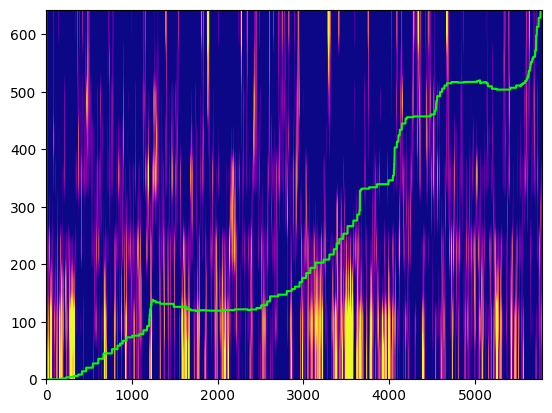

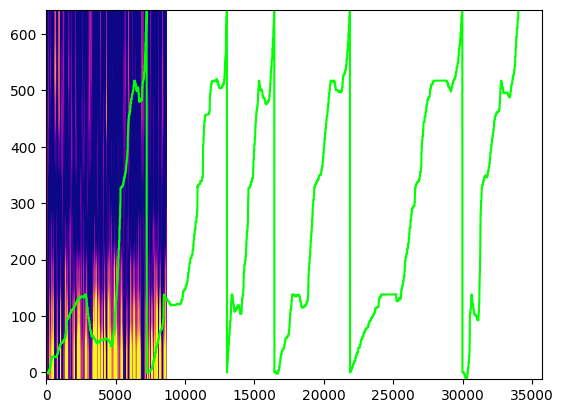

In [20]:
fig, ax = plt.subplots()
ax.imshow(results.causal_posterior.T[::-1], cmap="plasma", extent=(0, len(results.causal_posterior), np.min(position[start:end]), np.max(position[start:end])), vmin=0.1, vmax=0.2)
ax.set_aspect("auto")
ax.plot(position[start:end], c="lime")
# plt.savefig(os.path.join(figures_folder, f"causal_posterior_start_{start}_end_{end}.png"))
# plt.close("all")
# idxs = np.where(np.diff(position[start:end]) < -500)[0]
# idxs = np.insert(idxs, 0, 0)
# ax.vlines(idxs, np.min(position[start:end]), np.max(position[start:end]), ls="-", lw=2, colors="black")

In [6]:
idxs = np.where(np.diff(position) < -500)[0]
idxs = np.insert(idxs, 0, 0)
movement_var = estimate_movement_var(position, 60)

decoder = SortedSpikesDecoder(movement_var=movement_var,
                                replay_speed=1,
                                spike_model_penalty=0.5,
                                place_bin_size=np.sqrt(movement_var))

for trial_count in range(0, len(idxs) - 1):
    start = idxs[0]
    end = idxs[trial_count + 1]

    print(f"Using {end - start} spikes")

    # actual_spikes = get_nonempty_spikes_in_window(spikes, start, end)
    time_mask = get_time_mask_where_spikes_occur_in_window(spikes, start, end)
    # print(f"Found {int(time_mask.astype(int).sum())} usable spikes in window")
    print(f"Fitting model")
    decoder.fit(position[time_mask], spikes[time_mask])

    prediction_folder = os.path.join(figures_folder, f"s{start}_e{end}")
    os.mkdir(prediction_folder)

    for i, (trial_start, trial_end) in enumerate(zip(idxs[:-1], idxs[1:])):
        print(f"Predicting trial number: {i + 1} trial start: {trial_start} trial end: {trial_end}", end="\r")
        trial_number = i + 1
        results = decoder.predict(spikes[trial_start:trial_end], time=np.arange(trial_end-trial_start)/Fs)
        fig, ax = plt.subplots()
        ax.imshow(results.causal_posterior.T[::-1], cmap="plasma", extent=(0, len(results.causal_posterior), np.min(position[trial_start:trial_end]), np.max(position[trial_start:trial_end])), vmin=0.1, vmax=0.22)
        ax.set_aspect("auto")
        ax.plot(position[trial_start:trial_end], c="lime")
        output_filename = os.path.join(prediction_folder, f"results_fit_s{start}_e{end}_trial{trial_number}_s{trial_start}_e{trial_end}.png")
        plt.savefig(output_filename)
        plt.close(fig)
    print("")

Using 7243 spikes
Fitting model


NameError: name 'actual_spikes' is not defined

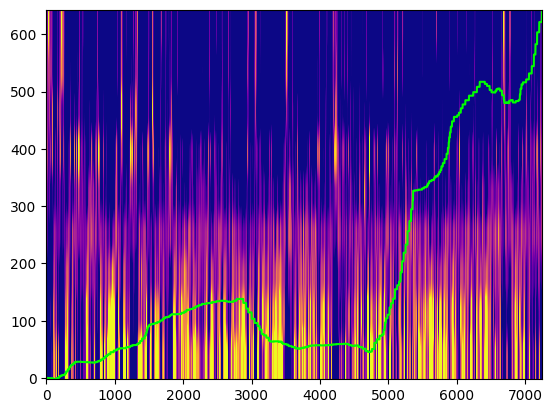

In [10]:
idxs = np.where(np.diff(position[start:end]) < -500)[0]
idxs = np.insert(idxs, 0, 0)
trial_number = 1

trial_start = idxs[trial_number - 1]
trial_end = idxs[trial_number]

fig, ax = plt.subplots()
ax.imshow(results.causal_posterior.T[::-1, trial_start:trial_end], cmap="plasma", extent=(0, (trial_end - trial_start), np.min(position[trial_start:trial_end]), np.max(position[trial_start:trial_end])), vmin=0.1, vmax=0.2)
ax.set_aspect("auto")
ax.plot(position[trial_start:trial_end], c="lime")
plt.savefig(os.path.join(figures_folder, f"causal_posterior_trial_{trial_number}_start_{trial_start}_end_{trial_end}.png"))
# plt.close("all")